In [5]:
import os
import glob
import pickle
import numpy as np

def parse_polyname(experiment_name):
    parts = experiment_name.split('_')
    index = -1
    for i,p in enumerate(name_parts):
        if '.json' in p:
            index = i

    s = ''
    for p in parts[1:index+1]:
        s+=p+'_'
    s += parts[-1]
    return  s[:-14].replace('.json','').replace('000','0').replace('.instance','')

def parse_logfile(filename):
    logfile = open(filename, 'r')
    lines = logfile.readlines()
    logfile.close()

    iteration_data = []
    current_iteration = {}

    for line in lines:
        if line.startswith('ITERATION:'):
            if current_iteration:
                iteration_data.append(current_iteration)
                current_iteration = {}
        elif line.startswith('summary'):
            current_iteration['summary'] = line.strip()
        elif line.startswith('number of regions step'):
            current_iteration['number_of_regions_step'] = int(line.split()[-1])
        elif line.startswith('number of regions total'):
            current_iteration['number_of_regions_total'] = int(line.split()[-1])
        elif line.startswith('tstep'):
            a = line.replace(',', '')
            current_iteration['tstep'] = float(a.split()[1])
            current_iteration['t_total'] = float(a.split()[3])
        elif line.startswith('tsample'):
            a = line.replace(',', '')
            current_iteration['tsample'] = float(a.split()[1])
            current_iteration['t_visgraph'] = float(a.split()[3])
        elif line.startswith('t_mhs'):
            current_iteration['t_mhs'] = float(line.split()[1])
        elif line.startswith('t_regions'):
            current_iteration['t_regions'] = float(line.split()[1])
        elif line.startswith('coverage'):
            current_iteration['coverage'] = float(line.split()[1])
        elif '[VisSeeder] Coverage met, terminated' in line:
            current_iteration['termination'] = line.strip()

    if current_iteration:
        iteration_data.append(current_iteration)
    return iteration_data


logs_directory = 'logs'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    

    # Extract the relevant values from the experiment name
    b = parse_polyname(experiment_name)
    if 'nxccv' in name_parts:
        N = 1
    elif 'postit' in name_parts:
        N = 3
    else:
        N=2
    #N = #int(name_parts[-3])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    pkl_files = os.listdir(data_directory)
    pkl_idx = np.argsort([int(s.replace('it_', '').replace('.pkl', '')) for s in pkl_files])
    
    #pickle_files.sort()
    
    last_pickle_file = data_directory+'/'+pkl_files[pkl_idx[-1]]#pickle_files[-1]#max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    

    iteration_dictionaries = parse_logfile(last_text_file)
    tsample = np.sum([i['tsample'] for i in iteration_dictionaries[1:]])
    tvis = np.sum([i['t_visgraph'] for i in iteration_dictionaries[1:]])
    tmhs = np.sum([0 for i in iteration_dictionaries[1:]])
    tregions = np.sum([i['t_total'] -i['t_visgraph']-i['tsample']  for i in iteration_dictionaries[1:]])
    coverage = iteration_dictionaries[-1]['coverage']
    # # Read the last line of the text file to extract coverage
    # with open(last_text_file, 'r') as file:
    #     lines = file.readlines()
    #     last_line = lines[-1].strip()
    #     coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if b not in grouped_experiments:
        grouped_experiments[b] = {}
    
    # Group experiments by 'N' value
    if N not in grouped_experiments[b]:
        grouped_experiments[b][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[b][N].append([
            np.sum(len(g) for g in data['rb']), coverage , data['ttotal'], tsample, tvis, tmhs, tregions])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with b = {b}:")
    for N, experiment_data in experiments.items():
        print(f"  Experiments with N = {N}:")
        for dat in experiment_data:
            print(f"    Experiment data: {dat}")

Experiments with b = fpg-poly_000300_h5.:
  Experiments with N = 1:
    Experiment data: [76, 0.9526, 946.9134435653687, 9.535, 114.538, 0, 1386.0430000000001]
    Experiment data: [75, 0.9526, 927.6305270195007, 10.027, 116.141, 0, 1357.2659999999998]
    Experiment data: [82, 0.9501, 1012.690022945404, 8.982000000000001, 116.31700000000001, 0, 1508.6550000000002]
  Experiments with N = 3:
    Experiment data: [65, 0.9504, 1069.5529987812042, 176.91899999999998, 18.609, 0, 35778.439000000006]
    Experiment data: [66, 0.9564, 1035.4909932613373, 182.599, 19.051, 0, 34916.117]
    Experiment data: [72, 0.9508, 1188.2772495746613, 199.79500000000002, 22.762, 0, 42386.846]
  Experiments with N = 2:
    Experiment data: [66, 0.9559, 826.5863094329834, 11.542, 114.517, 0, 1371.029]
    Experiment data: [75, 0.9542, 952.3554849624634, 12.433, 115.724, 0, 1486.844]
    Experiment data: [73, 0.956, 922.8208734989166, 17.135, 114.79, 0, 1511.0520000000001]
Experiments with b = srpg_iso_aligned

<ipython-input-5-1f3a2163938f>:127: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), coverage , data['ttotal'], tsample, tvis, tmhs, tregions])


In [6]:
polynames = []
for b in grouped_experiments.keys():
    polynames.append(b)

polynames.sort()

In [7]:
polynames

['cheese102.',
 'fpg-poly_000060_h1.',
 'fpg-poly_000070_h1.',
 'fpg-poly_000300_h5.',
 'srpg_iso_aligned_mc00172.']

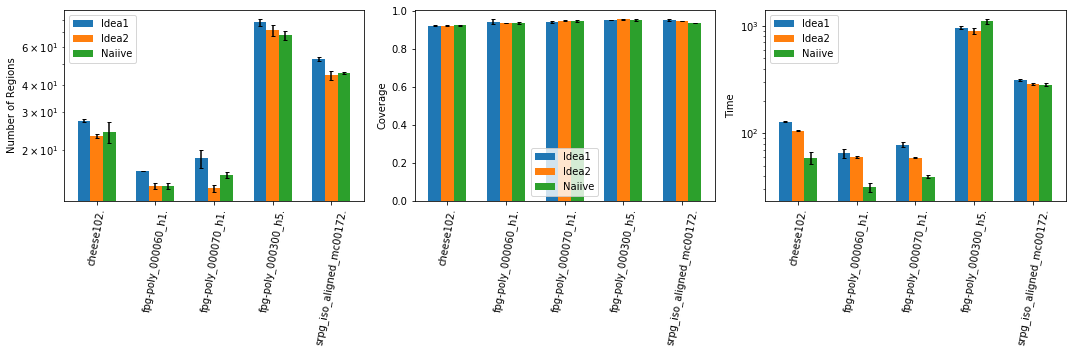

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = [b for b in polynames]
values1 = [np.mean(grouped_experiments[b][1], axis =0)[0] for b in polynames]
values2 = [np.mean(grouped_experiments[b][2], axis =0)[0] for b in polynames]
values3 = [np.mean(grouped_experiments[b][3], axis =0)[0] for b in polynames]
std1 = [np.std(grouped_experiments[b][1], axis =0)[0] for b in polynames]
std2 = [np.std(grouped_experiments[b][2], axis =0)[0] for b in polynames]
std3 = [np.std(grouped_experiments[b][3], axis =0)[0] for b in polynames]

# Set the position of the bars on the x-axis
ind = np.arange(len(categories))*3

# Set the width of the bars
width = 0.65

# Create the figure and axes
fig, axs = plt.subplots(nrows =1, ncols = 3, figsize = (15, 5))

ax = axs[0]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='Idea1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='Idea2')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='Naiive')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Number of Regions')
ax.set_title('')
ax.legend()


values1 = [np.mean(grouped_experiments[b][1], axis =0)[1] for b in polynames]
values2 = [np.mean(grouped_experiments[b][2], axis =0)[1] for b in polynames]
values3 = [np.mean(grouped_experiments[b][3], axis =0)[1] for b in polynames]
std1 = [np.std(grouped_experiments[b][1], axis =0)[1] for b in polynames]
std2 = [np.std(grouped_experiments[b][2], axis =0)[1] for b in polynames]
std3 = [np.std(grouped_experiments[b][3], axis =0)[1] for b in polynames]

ax = axs[1]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='Idea1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='Idea2')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='Naiive')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)

# Add labels, title, and legend
ax.set_ylabel('Coverage')
ax.set_title('')
ax.legend()



values1 = [np.mean(grouped_experiments[b][1], axis =0)[2] for b in polynames]
values2 = [np.mean(grouped_experiments[b][2], axis =0)[2] for b in polynames]
values3 = [np.mean(grouped_experiments[b][3], axis =0)[2] for b in polynames]
std1 = [np.std(grouped_experiments[b][1], axis =0)[2] for b in polynames]
std2 = [np.std(grouped_experiments[b][2], axis =0)[2] for b in polynames]
std3 = [np.std(grouped_experiments[b][3], axis =0)[2] for b in polynames]

ax = axs[2]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='Idea1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='Idea2')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='Naiive')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)

# Add labels, title, and legend
ax.set_ylabel('Time')
ax.set_yscale('log')
ax.set_title('')
ax.legend()

plt.tight_layout()
plt.savefig("cgshop_instances_clique.pdf")

In [7]:
grouped_experiments[polynames[0]]

{2: [[23, 0.9228, 106.08211326599121, 0.282, 64.025, 0, 41.77499999999999],
  [24, 0.9198, 107.5478196144104, 0.291, 63.199, 0, 44.05800000000001],
  [23, 0.9253, 103.82545018196106, 0.289, 62.133, 0, 41.403]]}

In [31]:
experiment_name

['experiment',
 'fpg-poly',
 '0000000300',
 'h5.instance.json',
 '2',
 '500',
 '0.100',
 '0727224631',
 '']

In [1]:
with open('graph.metis', 'r') as f:
    lines = f.readlines()

In [8]:
import numpy as np
edge_lines = lines[1:]
edge_lines_comp = [e.split(' ') for e in edge_lines]
num_e = np.sum(len(e) for e in edge_lines_comp)


<ipython-input-8-ed4885a9902e>:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_e = np.sum(len(e) for e in edge_lines_comp)


In [10]:
len(edge_lines)

500